<a href="https://colab.research.google.com/github/remifol/SystematicReview/blob/Removing-redundant-words/SystematicReview_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#general importation
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Natural Language processing
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score
import gensim
from gensim.models.word2vec import Word2Vec


#Pubmed tool importation
!pip install biopython
from Bio import Entrez
from Bio import Medline

#Other
from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

clear_output() #for clarity

In [0]:
Entrez.email = 'nsauthier@gmail.com'  #email required for Entrez database request
Path = 'drive/My Drive/Projet de maitrise/Revue systématique/Automatisation/Algorithme/'

In [0]:
def get_TitlesAbstracts(Data,subject):
  #Use Entrez library to get title and abstract from Pubmed
  #Tokenize it, 
  #if clean=True clean it and return it as a formatted list
  #if not don't clean to be later processed by embedding
  
  #Initialization
  Data.AbstractTriageStatus
  TitlesAbstracts = []
  PMID_temp = []
  batchsize = 100
  print('Beginning of extraction of ' + subject)
  
  #Creation of dictionary PMID:label
  Label_dict = Data[Data.ReviewSubject == subject][['PMID','AbstractTriageStatus']].set_index('PMID').to_dict()['AbstractTriageStatus'] 
  
  PMID_list = Data.loc[Data['ReviewSubject'] == subject, 'PMID'].values

  for NB_PMID in range(len(PMID_list)): #go in batches to avoid overloading Entrez
    PMID_temp.append(str(PMID_list[NB_PMID]))
    if (NB_PMID % batchsize) == 1:
    
      #Get the generator for the PMID list on medline
      record = Medline.parse(Entrez.efetch(db='pubmed', id = ','.join(PMID_temp), rettype = 'medline'))

      #Extraction of title, abstract and up-dated PMID list
      for record in record:
        if 'AB' in record.keys():
          TitleAbstract_temp = []
          TitleAbstract_temp.append(record['TI'] + ' ' + record['AB'])
          TitleAbstract_temp.append(Label_dict[int(record['PMID'])])
          TitleAbstract_temp.append(3) #For predicted lable
          TitlesAbstracts.append(TitleAbstract_temp)
      PMID_temp = []
      
  print('Subject ' + subject + ' extracted.')
      
  return TitlesAbstracts

def tok_clean(article_list, stemming=True, join=True):
  #transform the list of text to tokenise is
  #clean stop words and non alpha char
  #Option to stem it with porterstemmer
  #Option to join them to give back a single string
  
  stopWords = set(nltk.corpus.stopwords.words('english'))
  
  for text_num in range(len(article_list)):
    tokens = nltk.word_tokenize(article_list[text_num][0].replace('-',' '))
    tokens = [token.lower() for token in tokens if token.isalpha() and token not in stopWords]
    if stemming:
      porter_stemmer = PorterStemmer()
      tokens = [porter_stemmer.stem(token) for token in tokens]
    if join:
      article_list[text_num][0] =  " ".join(tokens)
    else:
      article_list[text_num][0] = tokens
    
  return article_list


def unpack(liste):
  #Transform a nested list into a numpy ndarray
  Number = len(liste)
  newlist = []
  label = []
  if isinstance(liste[0][0],str):#Input is a string of word
    for index in range(Number):
      newlist.append(liste[index][0])
      label.append(liste[index][1])
    return newlist, label

  else: #input is a list of word
    for index in range(Number):
      newlist.append(liste[index][0])
      label.append(np.ones(len(liste[index][0]))*liste[index][1])
      
  return np.concatenate(newlist,axis=0), np.concatenate(label,axis=0)

def metrics_calc(known,unkown):
  metrics = np.zeros([4,3])
  all_data = np.vstack((known, unkown))
  
  #know sensitivity
  metrics[0,0] = recall_score(known[:,0], known[:,1], pos_label=1)
  #know specificity
  metrics[1,0] =  recall_score(known[:,0], known[:,1], pos_label=0)
  #know f1
  if sum(known[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,0] =  0
  else:
    metrics[2,0] =  f1_score(known[:,0], known[:,1])
  #know proportion of included article
  metrics[3,0] =  np.sum(known[:,0])/len(known)
  #unkown sensitivity
  metrics[0,1] =  recall_score(unkown[:,0], unkown[:,1], pos_label=1)
  #unkown specificity
  metrics[1,1] =  recall_score(unkown[:,0], unkown[:,1], pos_label=0)
  #all f1
  if sum(unkown[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,1] =  0
  else:
    metrics[2,1] =  f1_score(unkown[:,0], unkown[:,1])
  #unkown proportion of included article
  metrics[3,1] =  np.sum(unkown[:,0])/len(unkown)
  #all sensitivity
  metrics[0,2] =  recall_score(all_data[:,0], all_data[:,1], pos_label=1)
  #all specificity
  metrics[1,2] =  recall_score(all_data[:,0], all_data[:,1], pos_label=0)
  #all f1
  if sum(all_data[:,1]) == 0:#to avoid warning when all predicted are =0
    metrics[2,2] =  0
  else:
    metrics[2,2] =  f1_score(all_data[:,0], all_data[:,1])
  #all proportion of included article
  metrics[3,2] =  np.sum(all_data[:,0])/len(all_data)
  
  return metrics

def get_count(X, Label, model):
  df_temp = pd.DataFrame({'words':X, 'label':Label})
  count = df_temp.groupby('label', as_index=False).count()
  negative = count['words'][count['label']==0].iloc[0]
  positive = count['words'][count['label']==1].iloc[0]

  df_temp['label'][df_temp['label'] == 1]=negative
  df_temp['label'][df_temp['label'] == 0]=-1*positive

  df_temp.groupby('words', as_index=False).sum()

  grouped = df_temp.groupby('words', as_index=False).sum()
  grouped = grouped.drop(grouped[grouped['label']==0].index)

  grouped['sign'] = grouped['label'].apply(lambda x:(np.sign(x)+1)/2)
  
  embeded = []
  unknown_words = 0
  known_words = 0
  for word in grouped['words']:
    try :
      embeded.append(model.get_vector(word))
    except KeyError: #unkown word
      embeded.append(np.zeros(model.vector_size)) #unkown tag
      unknown_words+=1
  known_words += len(grouped['words'])
  
  return np.asarray(embeded), grouped['sign'].values

def embed(liste, model):
  embeded = []
  for word in liste:
    try :
      embeded.append(model.get_vector(word))
    except KeyError: #unkown word
      embeded.append(np.zeros(model.vector_size)) #unkown tag
      
  return np.asarray(embeded)

In [0]:
def model_iterative_fit(Model, batchsize, path, Unknown, order = "most"):
  
  w2v_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
  print('Model Loaded')
  
  #Random extraction of first data until one included article.
  Known = []
  random.shuffle(Unknown)
  label = True
  count = 0 #To have at least 2 articles
  while label or count < 1:
    temp = Unknown.pop()
    Known.append(temp)
    label = not(temp[1])
    count+=1

  #initialization
  Nb_iter = len(Unknown)//batchsize
  Metrics = np.zeros([4,3,Nb_iter]) #col=[SN, SP, %=0], Row = [Known, Unknown, All]

  #Iteration to include by article batches
  for i in range(Nb_iter):
    start = time.time()
    average = []
    random.shuffle(Known)
    Known_X, Known_Y = unpack(Known)
    Known_X_count, Known_Y_count = get_count(Known_X, Known_Y, w2v_model)
    _ = Model.fit(Known_X_count, Known_Y_count)

    #Decision function = distance from the SVM line for each unknown
    for unkown_id in range(len(Unknown)):
      Unknown[unkown_id][2] = Model.decision_function(embed(Unknown[unkown_id][0],w2v_model))
      average.append(Unknown[unkown_id][2].mean())

    #Format of result as array with first col = true, second = predict
    result_temp = [] 
    for j in range(len(Unknown)):
      result_temp.append(np.array([Unknown[j][1],int((np.sign(np.sum(Unknown[j][2])) + 1)/2)]))
    result_unkown = np.reshape(result_temp, [len(result_temp),2])

    #Prediction of known with actual model
    for kown_id in range(len(Known)):
      Known[kown_id][2] = Model.decision_function(embed(Known[kown_id][0],w2v_model))

    #Format of result as array with first col = true, second = predict
    result_temp = [] 
    for j in range(len(Known)):
      result_temp.append(np.array([Known[j][1],int((np.sign(np.sum(Known[j][2])) + 1)/2)]))
    result_known = np.reshape(result_temp, [len(result_temp),2])

    #Model Update
    for batch_id in range(batchsize):
      if order == "most": 
        #pop the most sure from the unkown to the known list
        Known.append(Unknown.pop(average.index(max(average))))
        _ = average.pop(average.index(max(average)))
      elif order == "random":
        #pop one article in the list that<s in a random order
        Known.append(Unknown.pop())

    #Metrics
    Metrics[:,:,i] = metrics_calc(result_known,result_unkown)

    if i%10 == 0:
      print('{0}/{1} articles. Iteration time: {2:2.4f} sec per batch'.format(i*batchsize,Nb_iter*batchsize, time.time()-start))
    
  return Metrics

In [8]:
#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique()

TitlesAbstracts = get_TitlesAbstracts(Data, Subjects[1])

TitlesAbstracts = tok_clean(TitlesAbstracts, stemming=False, join=False)
#Unknown = embed_w2v(Path+'Models/GoogleNews-vectors-negative300.bin.gz',TitlesAbstracts)
#Unknown = embed_w2v(Path+'Models/ACEInhibitors_word2vec_64.bin',TitlesAbstracts)

Beginning of extraction of ADHD
Subject ADHD extracted.


In [9]:
svm_BOW = Pipeline([('vect', CountVectorizer(min_df=2)),
                    ('clf-svm', linear_model.SGDClassifier(loss = 'hinge',
                                                          penalty = 'l2', 
                                                          max_iter = 100, 
                                                          tol=1e-4,
                                                          class_weight = 'balanced',
                                                          )
                    )
                   ])

svm_W2V = linear_model.SGDClassifier(loss = 'hinge',
                                     penalty = 'l2', 
                                     max_iter =  1000,
                                     tol=1e-4,
                                     class_weight = 'balanced',
                                     warm_start = True)

order = "most"
Metrics = model_iterative_fit(svm_W2V, batchsize = 10, path = Path+'Models/GoogleNews-vectors-negative300.bin.gz', Unknown=TitlesAbstracts, order=order)

Model Loaded
0/740 articles. Iteration time: 0.7824 sec per batch
100/740 articles. Iteration time: 0.9327 sec per batch
200/740 articles. Iteration time: 1.0365 sec per batch
300/740 articles. Iteration time: 1.0633 sec per batch
400/740 articles. Iteration time: 1.0427 sec per batch
500/740 articles. Iteration time: 1.4526 sec per batch


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true s

600/740 articles. Iteration time: 1.1785 sec per batch


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true s

700/740 articles. Iteration time: 1.1559 sec per batch


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


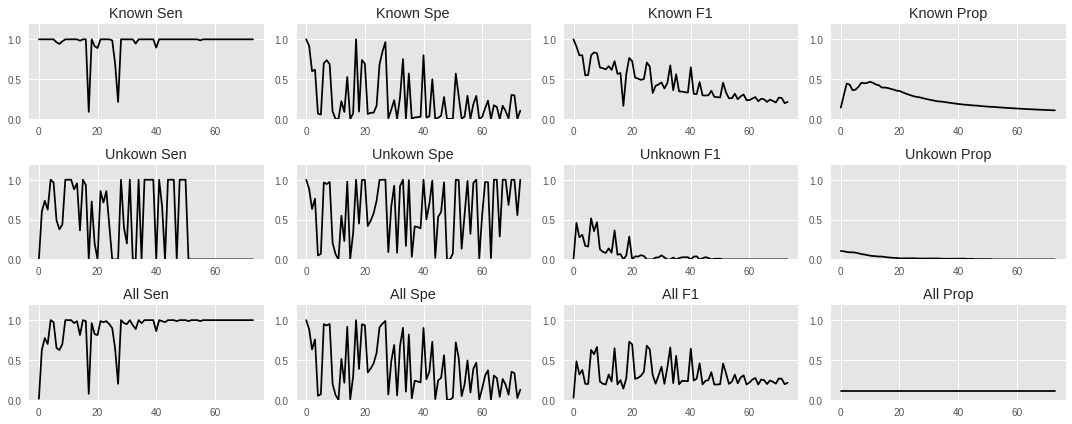

In [10]:
#Plot function
plt.style.use('ggplot')
x_axis = np.arange(0, max(Metrics.shape))

fig, ax = plt.subplots(3,4, figsize=(15, 6), facecolor='w', edgecolor='k')#figsize=(10,5), dpi=150)

titles = ('Known Sen',
          'Known Spe',
          'Known F1',
          'Known Prop',
          'Unkown Sen',
          'Unkown Spe',
          'Unknown F1',
          'Unkown Prop',
          'All Sen',
          'All Spe',
          'All F1',
          'All Prop')

ax = ax.ravel()

for i in range(12):
  color = 'tab:black'
  
  ax[i].set_title(titles[i])
  ax[i].plot(x_axis,Metrics[i%4,i//4,:], 'k')
  ax[i].set_ylim(0,1.2)


#ax1.legend(loc='right')
fig.tight_layout()
plt.show()

In [0]:
 #Version 2: Partial Fit
#TO BE BETTERED

#initialization
batchsize = 10
Nb_iter = len(Unknown)//batchsize
Metrics = np.zeros([4,3,Nb_iter]) #col=[SN, SP, %=0], Row = [Known, Unknown, All]
#Initialization of sklearn model
svm_W2V = linear_model.SGDClassifier(loss = 'log',
                                     penalty = 'l2', 
                                     max_iter =  1000,
                                     tol=1e-4)
                                     #class_weight = 'balanced')

#First pass with the first batch with 1 included
Known_X, Known_Y = unpack(Known)
svm_W2V.partial_fit(Known_X, Known_Y, classes=np.array([0,1]))

#Iteration to include by article batches
for i in range(Nb_iter):
  start = time.time()
  average = []
  #Decision function = distance from the SVM line for each unknown
  for unkown_id in range(len(Unknown)):
    Unknown[unkown_id][2] = svm_W2V.decision_function(Unknown[unkown_id][0])
    average.append(Unknown[unkown_id][2].mean())
  
  #Format of result as array with first col = true, second = predict
  result_temp = [] 
  for j in range(len(Unknown)):
    result_temp.append(np.array([Unknown[j][1], int((np.sign(np.sum(Unknown[j][2])) + 1)/2)]))
  result_unkown = np.reshape(result_temp, [len(result_temp),2])
  
  #Prediction of known with actual model
  for kown_id in range(len(Known)):
    Known[kown_id][2] = svm_W2V.decision_function(Known[kown_id][0])

  #Format of result as array with first col = true, second = predict
  result_temp = [] 
  for j in range(len(Known)):
    result_temp.append(np.array([Known[j][1],int((np.sign(np.sum(Known[j][2])) + 1)/2)]))
  result_known = np.reshape(result_temp, [len(result_temp),2])
  
  #Model Update
 
  #Selection of the batch of new articles with the most certainty
  #to ask the label. Simulated by tranfering them in the known list
  #and adding their weight to the model
  for batch_id in range(batchsize):
    #pop the most sure from the unkown to the known
    temp = []
    temp.append(Unknown.pop(average.index(max(average))))
    temp_x, temp_y = unpack(temp)
    svm_W2V.partial_fit(temp_x, temp_y)
    Known.append(temp[0])
    _ = average.pop(average.index(max(average)))
    
    
  #Metrics
  Metrics[:,:,i] = metrics_calc(result_known,result_unkown)

  if i%10 == 0:
    print('{0}/{1}. Iteration time: {2:2.4f} sec.'.format(i,Nb_iter, time.time()-start))